# Mini project 1, group AM

## Table of content
<!-- [1. Data Preparation](#1.-Data-Preparation)  
[2. Analysis](#2.-Analysis)  
[3. Results](#3.-Results)  -->

[Imports](#imports)

[Part 1](#1)
- [1) Structural preprocessing](#structural-preprocessing)
   - [a) Skull-stripping](#a-skull-stripping)
   - [b) Segmentation](#b-segmentation)
- [2) Functional preprocessing](#functional-preprocessing)
   - [a) Concatenation](#a-concatenation)
   - [b) Motion correction](#b-motion-correction)
   - [c) Co-registration (bonus)](#c-co-registration-(bonus))
   - [d) Gaussian smoothing](#d-gaussian-smoothing)
- [3) Experimental design matrix](#experimental-design-matrix)
- [4) GLM analysis](#glm-analysis)
- [5) Activation maps](#activation-maps)
- [6) Atlas overlay](#atlas-overlay)

[Part 2 : Variant 3](#2)
- [1) K-means clustering](#2-1)
- [2) Selection of a number of clusters](#2-2)
- [3) Pairwise similarity](#2-3)

## Imports

In [ ]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.plotting import plot_design_matrix
from nilearn.datasets import fetch_atlas_aal
from nilearn.plotting import plot_stat_map
from IPython.display import display
from nilearn.image import mean_img
import matplotlib.pyplot as plt
from nilearn import plotting

import mne
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt
from fsl.wrappers import mcflirt

# General purpose imports to handle paths, files etc
import pandas as pd
import numpy as np
import json
import subprocess
import gc

# Import for k-means
from sklearn.cluster import KMeans

from scipy.stats import pearsonr


# GLM analysis
import matplotlib.pyplot as plt
from nilearn import plotting, image
from nilearn.datasets import fetch_atlas_aal, load_mni152_template
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.plotting import plot_design_matrix, plot_stat_map
from IPython.display import display
from nilearn.image import mean_img
import nibabel as nib


Gtk-Message: 11:00:45.281: Failed to load module "canberra-gtk-module"


# Part 1

## 1) Structural preprocessing

### 1)a) Skull-stripping

In [2]:
anatomical_path = op.join("subject101410", "T1w", "T1w.nii.gz")
subject_id = '101410'
derivatives = op.join("derivatives", "preprocessed_data", "subject_101410")
deriv_anat = op.join(derivatives, "anat")
deriv_func = op.join(derivatives, "func")

for d in (deriv_anat, deriv_func):
    os.makedirs(d, exist_ok=True)

print("Derivatives will be written to:", os.path.abspath(derivatives))

Derivatives will be written to: /data/derivatives/preprocessed_data/subject_101410


In [3]:
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

22:05:02: Debug: Adding duplicate image handler for 'Windows bitmap file'
22:05:02: Debug: Adding duplicate animation handler for '1' type
22:05:02: Debug: Adding duplicate animation handler for '2' type
22:05:02: Debug: Adding duplicate image handler for 'Windows bitmap file'
22:05:02: Debug: Adding duplicate animation handler for '1' type
22:05:02: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:13376): Gtk-CRITICAL **: 22:05:02.551: gtk_window_resize: assertion 'height > 0' failed


In [4]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(anatomical_path)


(ipykernel_launcher.py:13376): Gdk-WARNING **: 22:05:11.798: gdkdrawable-x11.c:952 drawable is not a pixmap or window


In [6]:
def get_skull_stripped_anatomical(deriv_anat, anatomical_path, subject_id, robust=False):
    #wrapper around the BET tool from FSL
    #brain exctraction on T1w, save brain mask
    betted_brain_path = op.join(deriv_anat, 'sub-{}_T1w'.format(subject_id))
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(deriv_anat, 'sub-101410_T1w_mask')
get_skull_stripped_anatomical(deriv_anat, anatomical_path, subject_id, robust=True)

Done with BET.


In [7]:
fsleyesDisplay.load(resulting_mask_path)

In [8]:
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    
betted_brain_path = op.join(deriv_anat, 'sub-101410_T1w.nii.gz')
resulting_mask_path = op.join(deriv_anat, 'sub-101410_T1w_mask.nii.gz')

apply_fsl_math_approach(anatomical_path, resulting_mask_path, betted_brain_path)

In [9]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)

### 1)b) Segmentation

In [10]:
#Segmentation on anatomical skull-stripped brain
bet_path = op.join(deriv_anat, 'sub-101410_T1w')
fast_target = bet_path

[os.remove(f) for f in glob.glob(op.join(deriv_anat, '*fast*'))] # clean directory
segmentation_path = op.join(deriv_anat, 'sub-101410_T1w_fast')
fast(imgs=[fast_target], out=segmentation_path, n_classes=3)

{}

pve_0 in red : CSF \
pve_1 in green : grey matter \
pve_2 in blue : white matter

In [11]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(bet_path)
fsleyesDisplay.load(glob.glob(op.join(deriv_anat,'*pve_0*'))[0])
fsleyesDisplay.load(glob.glob(op.join(deriv_anat,'*pve_1*'))[0])
fsleyesDisplay.load(glob.glob(op.join(deriv_anat,'*pve_2*'))[0])
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'

## 2) Functional preprocessing

### 2)a) Concatenation

In [4]:
# Code to verify folder size
total_size = sum(os.path.getsize(op.join(deriv_func, f)) for f in os.listdir(deriv_func))
print(f"Remaining size in derivatives folder: {total_size / (1024**2):.2f} MB")


Remaining size in derivatives folder: 0.00 MB


In [5]:
# Create functional paths
functional_path_LR = op.join('subject101410', 'fMRI', 'tfMRI_MOTOR_LR', 'tfMRI_MOTOR_LR.nii') 
functional_path_RL = op.join('subject101410', 'fMRI', 'tfMRI_MOTOR_RL', 'tfMRI_MOTOR_RL.nii') 

print("Functional paths have been created")

Functional paths have been created


In [6]:
###########################################
# Variance Normalisation - Run LR
print("Normalizing variance for LR run")

# Calculate the standard deviation for LR
std_LR = subprocess.check_output(['fslstats', functional_path_LR, '-S']).decode().strip()
print(f"Global standard deviation for LR: {std_LR}")

# Compute the scaling factor (1 / (standard deviation))
scale_LR = 1 / float(std_LR)
print(f"Scaling factor for LR: {scale_LR}")

# Apply scaling to normalize the variance
scaled_LR_path = op.join(deriv_func, 'tfMRI_MOTOR_LR_varscaled.nii.gz')
subprocess.run(['fslmaths', functional_path_LR, '-mul', str(scale_LR), scaled_LR_path], check=True)
print(f"Saved normalized LR run: {scaled_LR_path}\n")

###########################################
# Variance Normalisation - Run RL
print("Normalizing variance for RL run")

# Calculate the standard deviation for RL
std_RL = subprocess.check_output(['fslstats', functional_path_RL, '-S']).decode().strip()
print(f"Global standard deviation for RL: {std_RL}")

# Compute the scaling factor for RL (1 / (standard deviation))
scale_RL = 1 / float(std_RL)
print(f"Scaling factor for RL: {scale_RL}")

# Apply scaling to normalize the variance
scaled_RL_path = op.join(deriv_func, 'tfMRI_MOTOR_RL_varscaled.nii.gz')
subprocess.run(['fslmaths', functional_path_RL, '-mul', str(scale_RL), scaled_RL_path], check=True)
print(f"Saved normalized RL run: {scaled_RL_path}\n")

###########################################
# Concatenate the two runs
print("Concatenating normalized runs...")

concat_path = op.join(deriv_func, f"sub-{subject_id}_motor_concat_varscaled.nii.gz")
subprocess.run(['fslmerge', '-t', concat_path, scaled_LR_path, scaled_RL_path], check=True)

print(f"Done! Final concatenated file: {concat_path}")

Normalizing variance for LR run
Global standard deviation for LR: 3348.690931
Scaling factor for LR: 0.000298624155111674
Saved normalized LR run: derivatives/preprocessed_data/subject_101410/func/tfMRI_MOTOR_LR_varscaled.nii.gz

Normalizing variance for RL run
Global standard deviation for RL: 3267.109431
Scaling factor for RL: 0.00030608096273467006
Saved normalized RL run: derivatives/preprocessed_data/subject_101410/func/tfMRI_MOTOR_RL_varscaled.nii.gz

Concatenating normalized runs...
Done! Final concatenated file: derivatives/preprocessed_data/subject_101410/func/sub-101410_motor_concat_varscaled.nii.gz


In [7]:
# Delete unnecessary paths and files to free memory
del std_RL, scale_RL, std_LR, scale_LR, scaled_LR_path, scaled_RL_path
gc.collect()

os.remove(op.join(deriv_func, "tfMRI_MOTOR_LR_varscaled.nii.gz"))
os.remove(op.join(deriv_func, "tfMRI_MOTOR_RL_varscaled.nii.gz"))

print("Unnecessary files deleted")

Unnecessary files deleted


### 2)b) Motion correction

In [8]:
# Correct the motion
print("Starting the motion correction")
path_motioncorrected = op.join(deriv_func, 'tfMRI_MOTOR_motioncorrected') # path to the motion corrected file
mcflirt(infile=concat_path, o=path_motioncorrected, plots=True, report=True, dof=6, mats=True)
print("Motion corrected")

Starting the motion correction


Processed data will be saved as derivatives/preprocessed_data/subject_101410/func/tfMRI_MOTOR_motioncorrected

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [284] to 8 mm pixels
Registering volumes ... [285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][406][407][408][409][410][411][412][413][414][415][416][417][418][419][420][421][422][423][424][425][42

refnum = 284
Original_refvol = -1


Registering volumes ... [285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][406][407][408][409][410][411][412][413][414][415][416][417][418][419][420][421][422][423][424][425][426][427][428][429][430][431][432][433][434][435][436][437][438][439][440][441][442][443][444][445][446][447][448][449][450][451][452][453][454][455][456][457][458][459][460][461][462][463][464][465][466][467][468][469][470][471][472][473][474][475][476][477][478][479][

Motion corrected


In [20]:
# Display result
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(concat_path)
fsleyesDisplay.load(path_motioncorrected)
print("Motion corrected done")

Motion corrected done


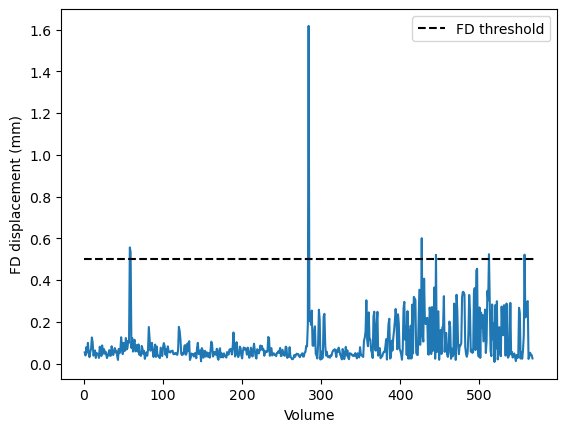

Indices of frames of motion above threshold: [58, 59, 284, 427, 445, 512, 557]


In [11]:
mc_par_path = op.join(deriv_func, 'tfMRI_MOTOR_motioncorrected.par')

def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(mc_par_path)
mot_params

def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rotation_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    
    convert_rot_to_arc = rotation_params*90                                    # transform from angle to arc of circle for a radius of 50mm, normal used values are 50 or 90 mm
    translation_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = convert_rot_to_arc.abs().sum(axis=1) + translation_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()
threshold = 0.5

#%matplotlib inline
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 570,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

print(f"Indices of frames of motion above threshold: {(np.where(fd > threshold)[0] + 1).tolist()}")

In [9]:
###########################################
# CODE WHOSE OBJECTIVE WAS TO CREATE A NEW FILE WHERE THE POINTS WERE EXTRAPOLATED (ALTERNATIVE METHOD)
###########################################

#input_file = op.join(deriv_func, 'tfMRI_MOTOR_motioncorrected.nii.gz')
#output_file = op.join(deriv_func, 'tfMRI_MOTOR_motioncorrected_nooutliers.nii.gz')

#img = nib.load(input_file)
#data = img.get_fdata()

#data_corrected = data.copy()

#outliers = []
#def no_outliers(fd, threshold):
#    fd_new = fd.copy()
#    n = len(fd)
#    for index, val in enumerate(fd):
#        if (val > threshold):
#            before = None
#            after = None
#            before_d = None
#            after_d = None
#            for j in range(1, 5):           
#                if index - j >= 0 and fd[index - j] <= threshold and before is None:
#                    before = fd[index - j]
#                    before_d = data_corrected[..., index - j]
#                if index + j < n and fd[index + j] <= threshold and after is None:
#                    after = fd[index + j]
#                    after_d = data_corrected[..., index + j]
#                if before is not None and after is not None:
#                    break
#            if before is not None and after is not None:
#                fd_new[index] = (before + after) / 2
#                data_corrected[..., index] = (before_d + after_d) / 2
#            elif before is not None:
#                fd_new[index] = before
#                data_corrected[..., index] = before_d
#            elif after is not None:
#                fd_new[index] = after
#                data_corrected[..., index] = after_d
#    outliers = (np.where(fd_new > threshold)[0] + 1).tolist()
#    return fd_new, outliers
#fd_new, outliers = no_outliers(fd, threshold)

#print(f"Indices of frames of motion above threshold: {outliers}")

#new_img = nib.Nifti1Image(data_corrected, affine=img.affine, header=img.header)
#nib.save(new_img, output_file)

#print(f" data_corrected avec interpolation sauvegardé : {output_file}")

In [13]:
outliers = []
def no_outliers(fd, threshold):
    fd_new = fd.copy()
    n = len(fd)
    for index, val in enumerate(fd):
        if (val > threshold):
            before = None
            after = None
            for j in range(1, 5):           
                if index - j >= 0 and fd[index - j] <= threshold and before is None:
                    before = fd[index - j]
                if index + j < n and fd[index + j] <= threshold and after is None:
                    after = fd[index + j]
                if before is not None and after is not None:
                    break
            if before is not None and after is not None:
                fd_new[index] = (before + after) / 2
            elif before is not None:
                fd_new[index] = before
            elif after is not None:
                fd_new[index] = after
    outliers = (np.where(fd_new > threshold)[0] + 1).tolist()
    return fd_new, outliers
fd_new, outliers = no_outliers(fd, threshold)

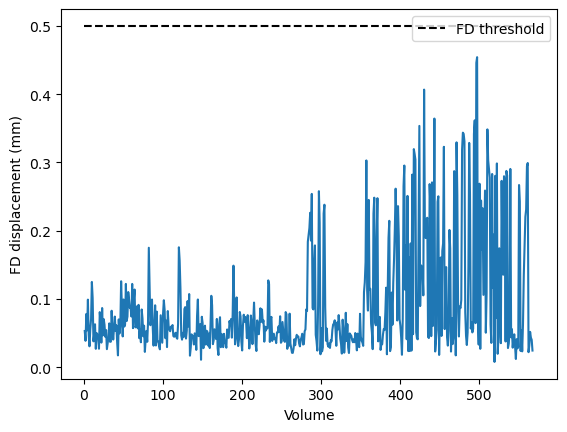

Indices of frames of motion above threshold: []


In [14]:
plt.plot(list(range(1, fd_new.size+1)), fd_new)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 570,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

print(f"Indices of frames of motion above threshold: {(np.where(fd_new > threshold)[0] + 1).tolist()}")

In [11]:
######################################
# THIS CELL DELETES THE DERIVATIVES FOLDER. DO NOT RUN UNLESS A REBOOT IS NECESSARY!!!!!
######################################

#import shutil
#import os

#folder_to_clear = "derivatives/preprocessed_data/subject_101410"
#if os.path.exists(folder_to_clear):
#     shutil.rmtree(folder_to_clear)
#     print("Dossier supprimé pour libérer de l'espace.")

Dossier supprimé pour libérer de l'espace.


### 2)c)Coregistration functional on anatomical

In [10]:
# Redo some path 

anatomical_path = op.join("subject101410", "T1w", "T1w.nii.gz") #the original brain
betted_brain_path = op.join(deriv_anat, 'sub-{}_T1w'.format(subject_id)) #brain without skull
segmentation_path = op.join(deriv_anat, 'sub-101410_T1w_fast')
path_motioncorrected = op.join(deriv_func, 'tfMRI_MOTOR_motioncorrected') # path to the motion corrected file

In [22]:
epi_image = nib.load(path_motioncorrected+'.nii.gz')

shape = epi_image.shape

print(shape)

(91, 109, 91, 568)


In [31]:
# We use the motion corrected EPI
epi_source = path_motioncorrected
white_matter_segmentation = op.join(deriv_anat,'sub-101410_T1w_fast_pve_2.nii.gz') #white matter segmentation
whole_t1 = anatomical_path
skull_stripped_t1 = betted_brain_path
output_path = op.join(deriv_func, 'sub-101410_coreg_anat_funct')
ref_vol_name =  op.join(deriv_func,'sub-101410_tfMRI_MOTOR_motioncorrected_one_volume')
#select a volume
fslroi(epi_source, ref_vol_name, str(200), str(1))
#run epi_reg
subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), '--out={}'.format(output_path), '--wmseg={}'.format(white_matter_segmentation) ])
print("epi_reg finished !")

FLIRT pre-alignment
Running BBR
0.986682 0.998131 0.054231 -0.028169 0.000000 -0.056371 0.995060 -0.081717 0.000000 0.023598 0.083152 0.996257 0.000000 5.839699 -20.641233 19.883628 1.000000 
epi_reg finished !


In [32]:
#Visualize the results functional overlay on anatomical
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path) 
fsleyesDisplay.load(output_path)

### 2)d) Gaussian smoothing

In [15]:
#Voxels size [mm]
print(source.header.get_zooms())

#We redo some paths
path_motioncorrected = op.join(deriv_func, 'tfMRI_MOTOR_motioncorrected') # path to the motion corrected file
output_path = path_motioncorrected

NameError: name 'source' is not defined

In [ ]:
print("smoothing 4mm")
cmd = 'fslmaths {} -s {} {}_smoothed-4mm'.format(output_path, 4/2.3548, output_path)
subprocess.run(['fslmaths',output_path, '-s', str(4/2.3548), '{}_smoothed-4mm'.format(output_path)])
results_smoothing_4mm = '{}_smoothed-4mm.nii.gz'.format(output_path)

smoothing 4mm


In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(output_path)
fsleyesDisplay.load(results_smoothing_4mm)

## 3) Experimental design matrix

In [ ]:
events_path = '/data/subject101410/fMRI/tfMRI_MOTOR_LR/events_LR.csv'

events = pd.read_csv(op.join(events_path), sep=',')

print("Events Table")
pd.set_option('display.float_format', '{:,.2f}'.format)
display(events.head(11))

In [ ]:
# Paramaters
events.rename(columns={'condition': 'trial_type'}, inplace=True)
TR = img.header.get_zooms()[3]   # repetition time
last_scan = int(np.ceil(events['onset'].max() / TR)) + 1 
img_trimmed = img.slicer[:, :, :, :last_scan]
frame_times = np.arange(last_scan) * TR  # time vector for each volume
print('done with parameters')

# Design matrix creation
design_matrix = make_first_level_design_matrix(
    frame_times,
    events,
    hrf_model='spm',
    drift_model='cosine',
    high_pass=0.01)

# Plot design matrix
print('Design Matrix')
plot_design_matrix(design_matrix)
plt.show()

## 4) GLM analysis

In [ ]:
mask_img = image.load_img(resulting_mask_path)
mask_epi = image.resample_to_img(mask_img, img, interpolation='nearest')

first_level_model = FirstLevelModel(
    t_r=0.72,
    noise_model='ar1',
    standardize=False,
    hrf_model='spm',
    drift_model='cosine',
    high_pass=.01,
    mask_img=mask_epi    
)

contrast = 'lh + rh - lf - rf'
fmri_glm = first_level_model.fit(img, events)

# Compute and plot t-map for each regressor and run
for reg in cols_to_keep:
    t_map = fmri_glm.compute_contrast(reg, output_type='stat')
    plotting.plot_stat_map(
        t_map,
        threshold=3.0,
        display_mode='ortho',
        title=f'Statistical map: {reg}'
    )
plt.show()

## 5) Activation maps

In [ ]:
print(fmri_glm.design_matrices_[0].columns)

activation_map = fmri_glm.compute_contrast(contrast, output_type='stat')
plotting.plot_stat_map(
    activation_map,
    threshold=0.5,        
    display_mode='ortho',
    title='Hand > Foot Activation Map'
)

## 6) Atlas overlay

In [ ]:
atlas = datasets.fetch_atlas_aal()
atlas_resampled = image.resample_to_img(atlas.maps, activation_map, interpolation='nearest')
bg = load_mni152_template()

nib.save(activation_map, 'activation_map.nii.gz')
nib.save(atlas_resampled, 'atlas_resampled.nii.gz')
nib.save(bg, 'bg.nii.gz') 
activation_path = 'activation_map.nii.gz'
atlas_path = 'atlas_resampled.nii.gz'
bg_path = 'bg.nii.gz'

subprocess.Popen(['fsleyes', bg_path, activation_path, atlas_path])

# Part 2 : Variant 3
## 1) K-means clustering

In [4]:
results_smoothing = '{}_smoothed-4mm.nii.gz'.format(output_path)
img = nib.load(results_smoothing)
affine = img.affine
data = np.asanyarray(img.dataobj)
print(data.shape)

(91, 109, 91, 568)


In [5]:
#Preprocessing
vol_shape = data.shape[:3]
n_vols    = data.shape[3] #number of volumes

#remove background
slice_non_background = data[..., 0] != 0
samples = data[slice_non_background, :]

#calculate the means
spatial_means = samples.mean(axis=1, keepdims=True)
row_means = np.repeat(spatial_means, samples.shape[1], axis=1)

#centering data : subtract the means
X_kmeans = samples - row_means

print(samples.shape)

(393197, 568)


In [4]:
max_nb_clusters = 9
avg_dist_samples = []
for nb_cluster in range(1, max_nb_clusters):
    kmeans = KMeans(n_clusters=nb_cluster, random_state=0, n_init="auto").fit(X_kmeans.T)
    avg_dist_samples.append(kmeans.inertia_)

## 2) Selection of a number of clusters

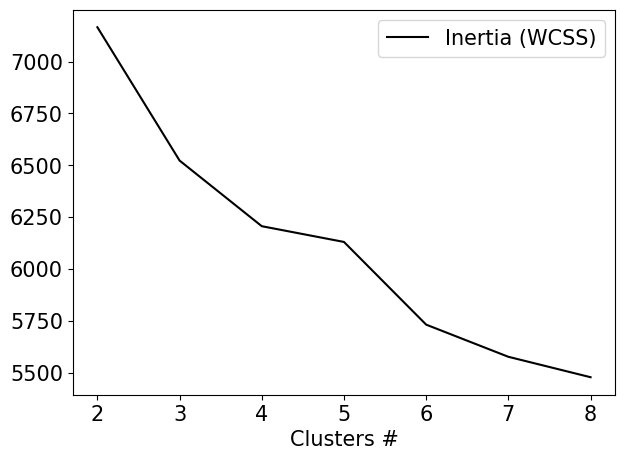

In [6]:
fig, ax = plt.subplots(1, figsize=(7,5))

ax.plot(np.arange(1, 
    len(avg_dist_samples)+1)[1:], #skip first x (to zoom on the elbow)
    avg_dist_samples[1:], #skip first y
    label='Inertia (WCSS)', c='k'
)

ax.set_xlabel('Clusters #', size=15)
ax.legend(prop={'size':15})
ax.tick_params(axis='both', which='major', labelsize=15)

In [8]:
nb_clusters = 3
kmeans = KMeans(n_clusters=nb_clusters, random_state=0, n_init="auto").fit(X_kmeans.T)

kmeans_clusters = []
for cluster_idx in range(nb_clusters):
    kmeans_component = np.zeros(vol_shape)
    kmeans_component[slice_non_background] = kmeans.cluster_centers_[cluster_idx]
    kmeans_clusters.append(kmeans_component)
    

Cluster 1
Cluster 2
Cluster 3


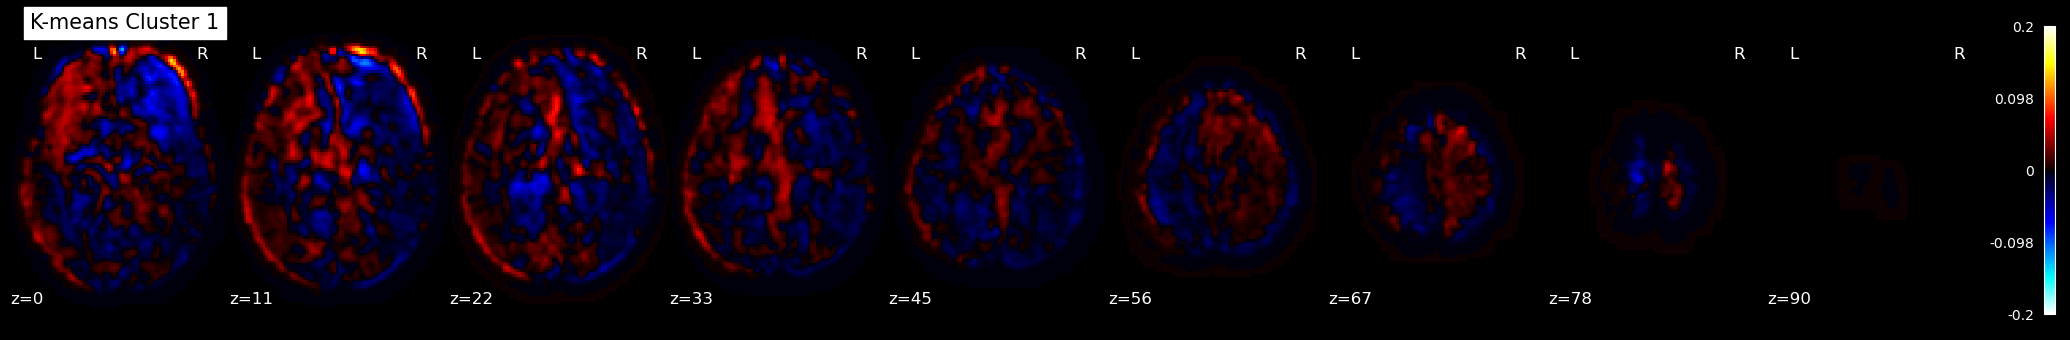

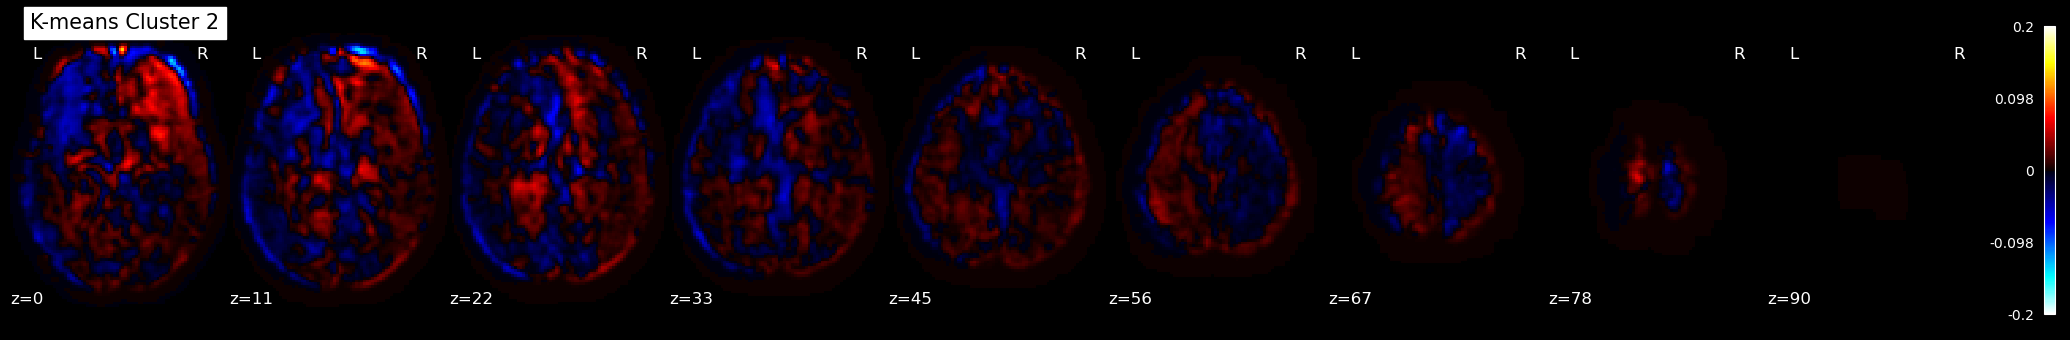

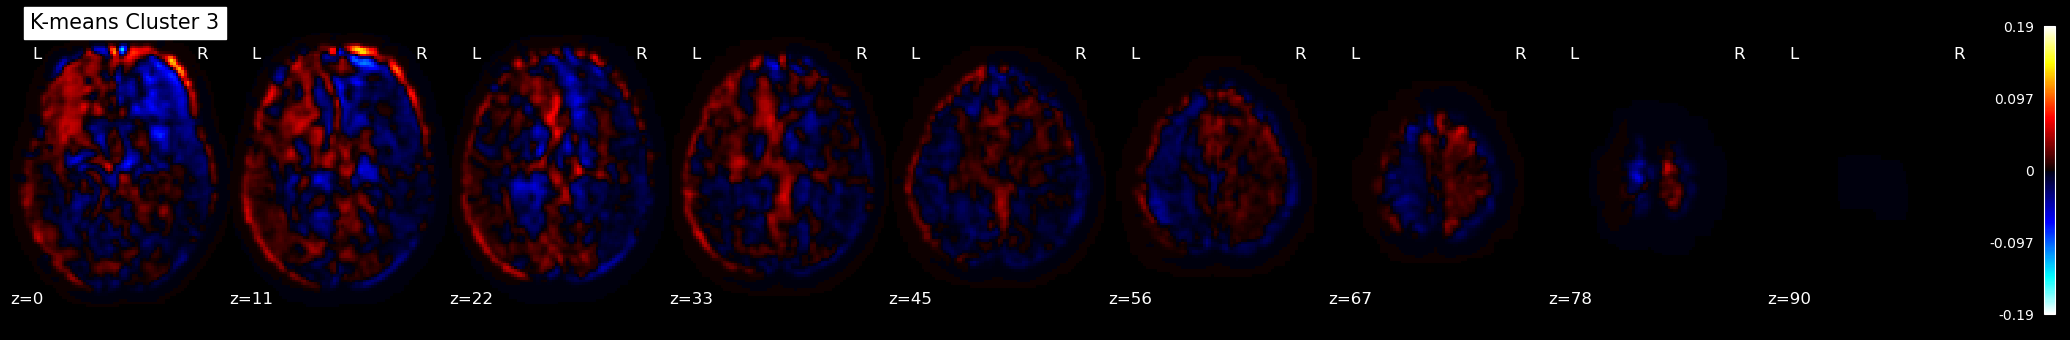

In [9]:
#Display centroids
mean_img_ = mean_img(img)
zmax = vol_shape[2] - 1
cut_coords = list(np.linspace(0, zmax, 9, dtype=int))  #9 axial slices

for i, centroid in enumerate(kmeans_clusters):
    print(f"Cluster {i+1}")
    plot_stat_map(
        nib.Nifti1Image(centroid, affine),
        bg_img=mean_img_,
        display_mode='z',
        cut_coords=cut_coords,
        threshold=0,
        colorbar=True,
        black_bg=True,
        title=f"K-means Cluster {i+1}"
    )

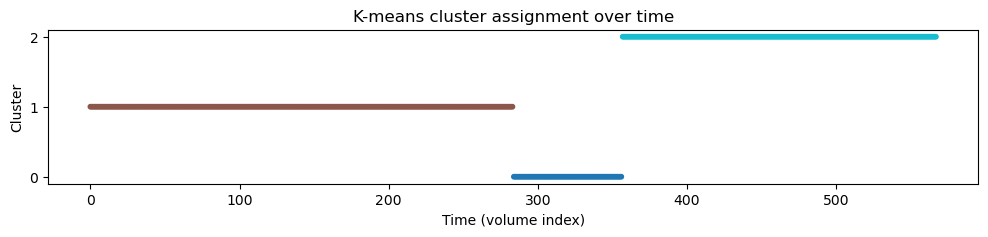

In [10]:
labels = kmeans.labels_

plt.figure(figsize=(12, 2))
plt.scatter(np.arange(len(labels)), labels, c=labels, cmap='tab10', s=10)
plt.xlabel('Time (volume index)')
plt.ylabel('Cluster')
plt.title('K-means cluster assignment over time')
plt.yticks(np.arange(kmeans.n_clusters))
plt.show()


## 3) Pairwise similarity

In [12]:
nb_clusters = 5
kmeans = KMeans(n_clusters=nb_clusters, random_state=0, n_init="auto").fit(X_kmeans.T)

kmeans_clusters = []
for cluster_idx in range(nb_clusters):
    kmeans_component = np.zeros(vol_shape)
    kmeans_component[slice_non_background] = kmeans.cluster_centers_[cluster_idx]
    kmeans_clusters.append(kmeans_component)

In [10]:
C = kmeans.cluster_centers_

m = 5
sim = np.zeros((m, m))

for i in range(m):
    for j in range(m):
        sim[i, j] = pearsonr(C[i], C[j])[0]  #correlation coefficient

print("Similarity matrix (Pearson):")
print(np.round(sim, 3))

Similarity matrix (Pearson):
[[ 1.     0.999 -0.999 -0.997 -0.422]
 [ 0.999  1.    -0.997 -0.993 -0.387]
 [-0.999 -0.997  1.     0.999  0.451]
 [-0.997 -0.993  0.999  1.     0.49 ]
 [-0.422 -0.387  0.451  0.49   1.   ]]


Cluster 1
Cluster 2
Cluster 3
Cluster 4
Cluster 5


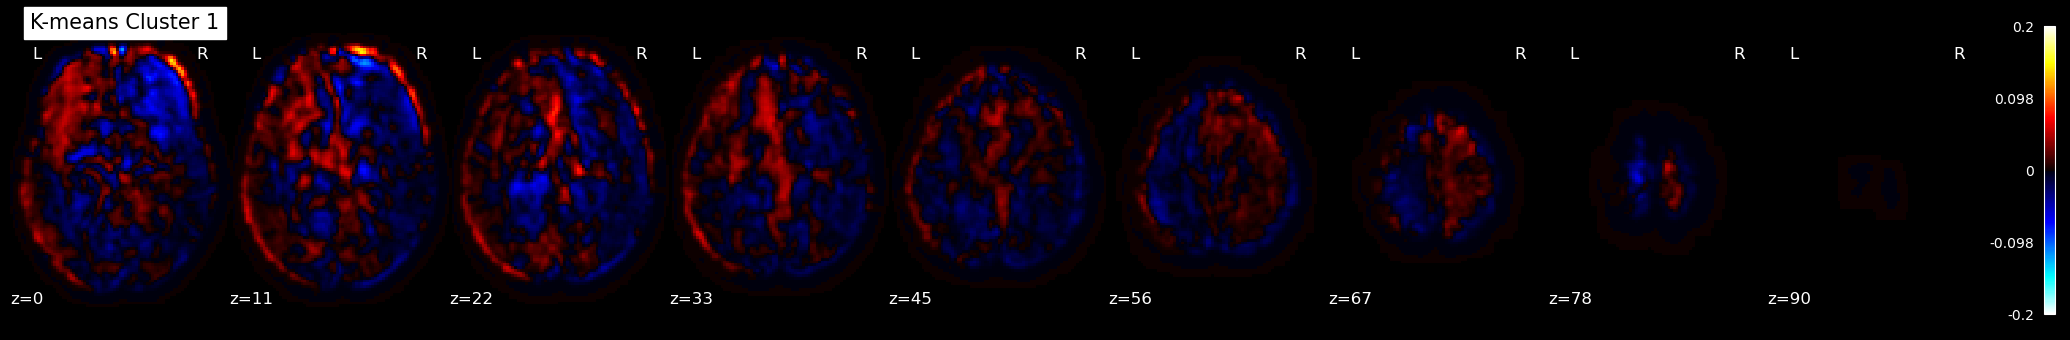

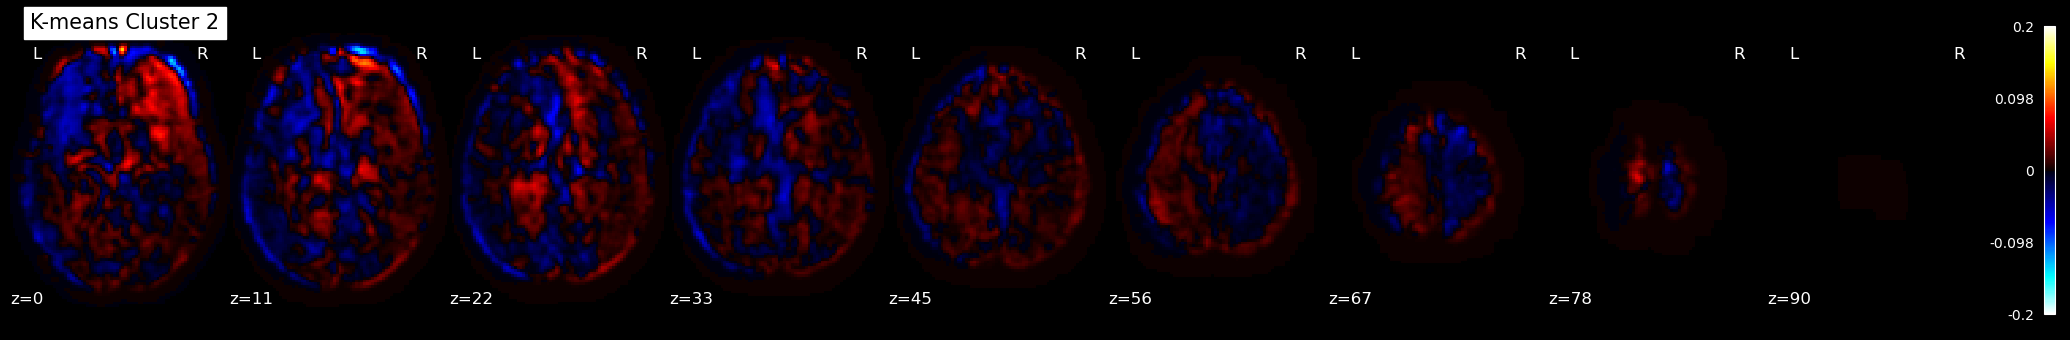

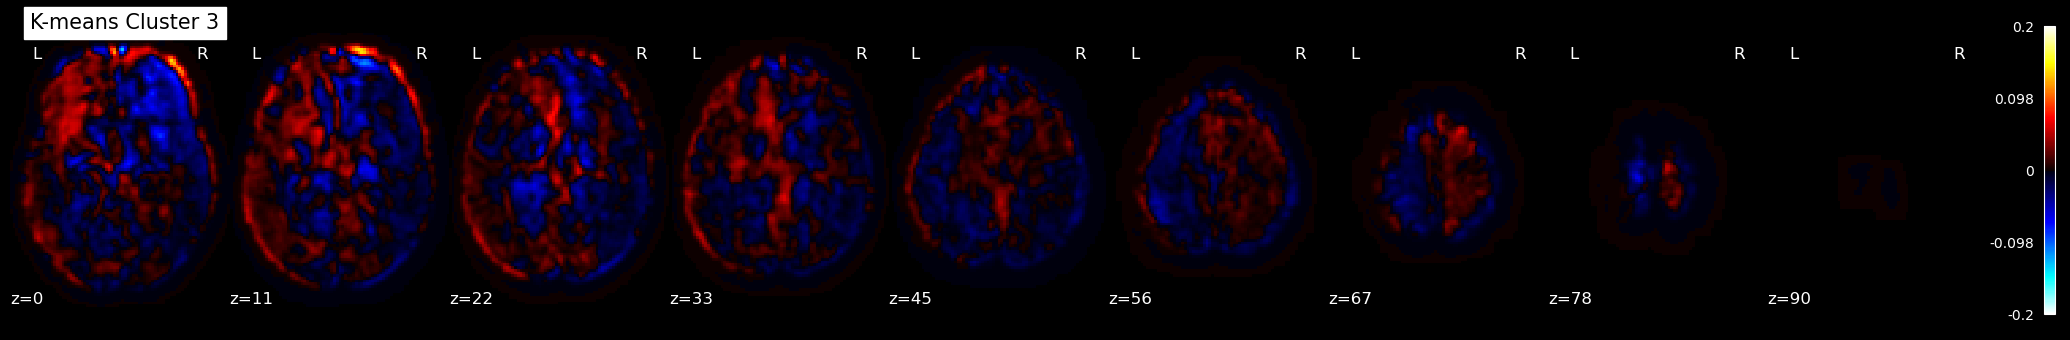

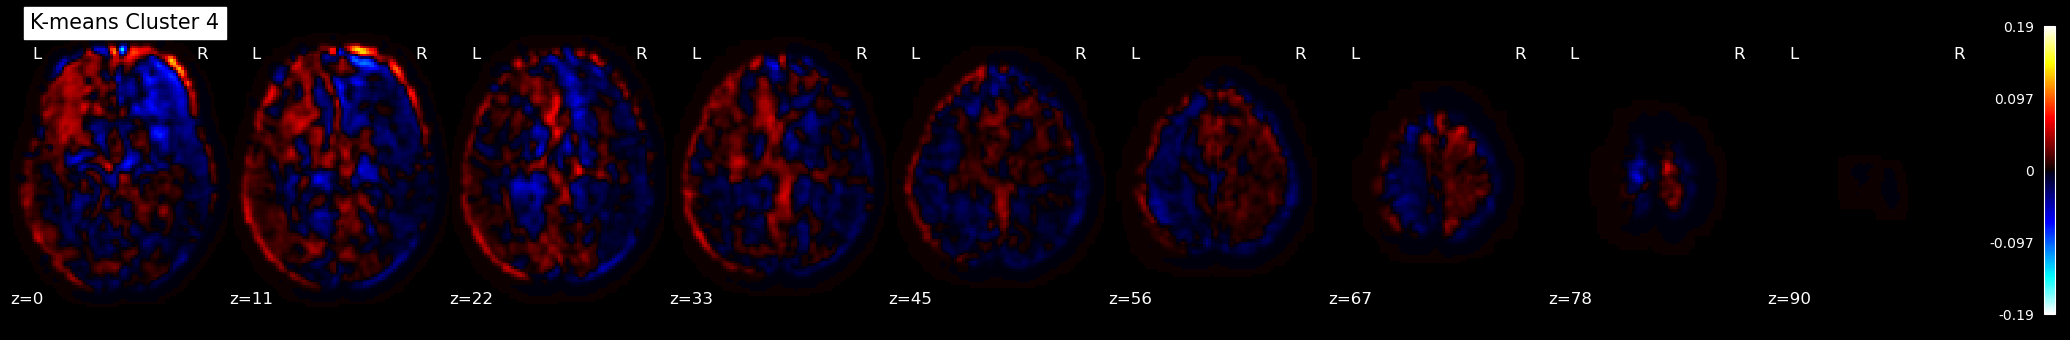

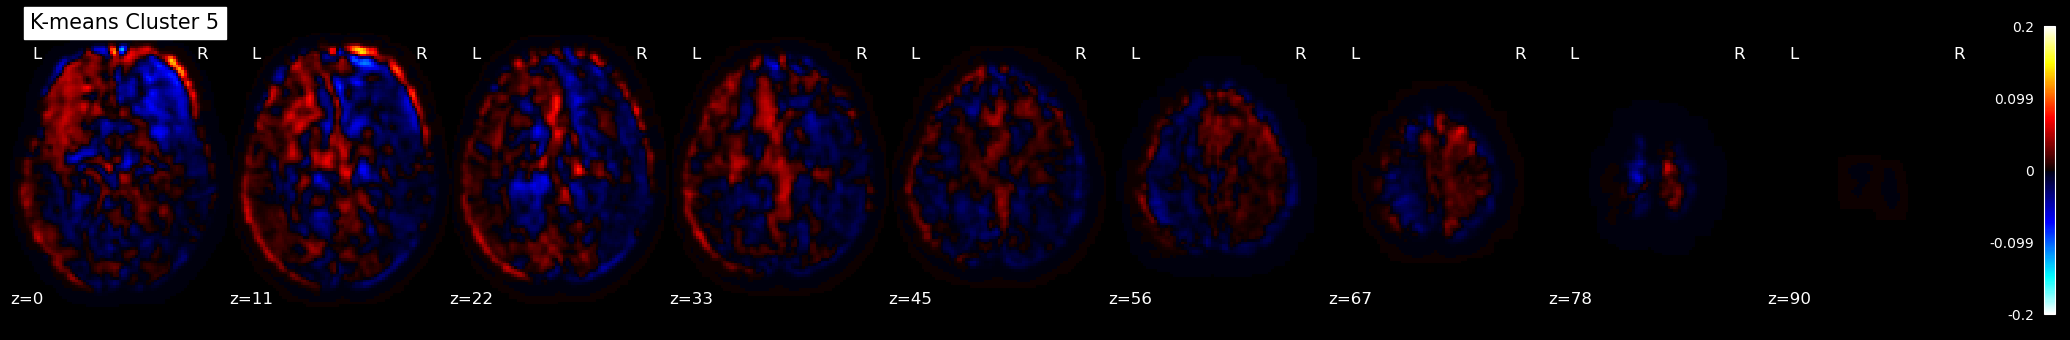

In [15]:
#Display centroids
mean_img_ = mean_img(img)
zmax = vol_shape[2] - 1
cut_coords = list(np.linspace(0, zmax, 9, dtype=int))  #9 axial slices

for i, centroid in enumerate(kmeans_clusters):
    print(f"Cluster {i+1}")
    plot_stat_map(
        nib.Nifti1Image(centroid, affine),
        bg_img=mean_img_,
        display_mode='z',
        cut_coords=cut_coords,
        threshold=0,
        colorbar=True,
        black_bg=True,
        title=f"K-means Cluster {i+1}"
    )

# END